In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ctgan import CTGAN
from ctgan import load_demo
import data_describe as dd
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data = pd.read_csv('../data/S&P 500 Materials 100-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data

,date,S&P 500,S&P 500 Materials (Sector),S&P 500 Performance (%),S&P 500 Materials (Sector) Performance (%),S&P 500 Materials (Sector) Outperform/Underperform,overall,transportation,energy,energy commodities,fuels and utilities,transportation services
0,1993-05-04,444.05,90.040001,-2.967463,2.504560,2.5045595402805043,144.300,129.900,103.900,96.400,121.400,162.600
1,1993-05-05,444.52,89.930000,-3.741880,1.926779,OUTPERFORM,144.300,129.900,103.900,96.400,121.400,162.600
2,1993-05-06,443.26,89.500000,-3.958573,1.727662,OUTPERFORM,144.300,129.900,103.900,96.400,121.400,162.600
3,1993-05-07,442.31,89.239998,-3.868640,1.767586,OUTPERFORM,144.300,129.900,103.900,96.400,121.400,162.600
4,1993-05-10,442.80,88.970001,-3.514697,0.998984,OUTPERFORM,144.300,129.900,103.900,96.400,121.400,162.600
...,...,...,...,...,...,...,...,...,...,...,...,...
7194,2021-11-24,4701.46,551.250000,5.426902,-3.082040,UNDERPERFORM,280.126,250.105,263.553,309.682,272.154,326.397
7195,2021-11-26,4594.62,541.520020,4.573863,-3.170314,UNDERPERFORM,280.126,250.105,263.553,309.682,272.154,326.397
7196,2021-11-29,4655.27,544.190002,8.977288,1.075404,UNDERPERFORM,280.126,250.105,263.553,309.682,272.154,326.397
7197,2021-11-30,4567.00,530.679993,6.305224,-1.145619,UNDERPERFORM,280.126,250.105,263.553,309.682,272.154,326.397


## Using data after 2010

In [3]:
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2010]
data

,year,month,date,S&P 500,S&P 500 Materials (Sector),S&P 500 Performance (%),S&P 500 Materials (Sector) Performance (%),S&P 500 Materials (Sector) Outperform/Underperform,overall,transportation,energy,energy commodities,fuels and utilities,transportation services,dow
200,2010,1,2010-01-14,1148.46,206.130005,8.787618,16.569588,OUTPERFORM,217.281,191.978,209.624,239.914,212.638,257.050,3
201,2010,2,2010-02-11,1078.47,187.250000,1.716544,5.487018,OUTPERFORM,217.353,191.375,209.326,237.315,214.506,257.804,3
202,2010,3,2010-03-11,1150.24,199.759995,2.657837,2.241780,UNDERPERFORM,217.403,191.249,209.219,237.093,214.821,258.306,3
203,2010,4,2010-04-08,1186.44,210.339996,13.110628,12.235202,UNDERPERFORM,217.290,190.231,206.631,232.440,214.303,258.969,3
204,2010,5,2010-05-13,1157.44,195.979996,-0.285160,-5.469810,UNDERPERFORM,217.199,189.426,203.764,227.477,213.427,259.454,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2021,7,2021-07-08,4320.82,511.019989,-7.184331,-6.095300,OUTPERFORM,273.092,236.783,242.958,276.734,262.483,326.470,3
339,2021,8,2021-08-12,4460.83,541.940002,-6.940799,-4.780817,OUTPERFORM,274.214,237.107,245.847,280.047,265.333,323.329,3
340,2021,9,2021-09-09,4493.28,525.940002,-1.171440,-2.502595,UNDERPERFORM,276.590,241.826,255.010,293.342,270.870,323.995,3
341,2021,10,2021-10-14,4438.26,526.789978,3.749053,2.205967,UNDERPERFORM,278.524,246.749,261.257,305.653,271.467,326.256,3


In [4]:
original = data[['S&P 500 Materials (Sector) Outperform/Underperform','month','overall','transportation',\
                 'energy', 'energy commodities', 'fuels and utilities','transportation services']]

In [5]:
data.drop(columns=['date','S&P 500 Materials (Sector) Outperform/Underperform','year'], inplace=True)
data.head()

,month,S&P 500,S&P 500 Materials (Sector),S&P 500 Performance (%),S&P 500 Materials (Sector) Performance (%),overall,transportation,energy,energy commodities,fuels and utilities,transportation services,dow
200,1,1148.46,206.130005,8.787618,16.569588,217.281,191.978,209.624,239.914,212.638,257.050,3
201,2,1078.47,187.250000,1.716544,5.487018,217.353,191.375,209.326,237.315,214.506,257.804,3
202,3,1150.24,199.759995,2.657837,2.241780,217.403,191.249,209.219,237.093,214.821,258.306,3
203,4,1186.44,210.339996,13.110628,12.235202,217.290,190.231,206.631,232.440,214.303,258.969,3
204,5,1157.44,195.979996,-0.285160,-5.469810,217.199,189.426,203.764,227.477,213.427,259.454,3


In [6]:
original['Performance'] = np.where(original['S&P 500 Materials (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','transportation',\
                 'energy', 'energy commodities', 'fuels and utilities','transportation services']]

In [7]:
dd.data_summary(original)

,Info
Rows,143
Columns,8
Size in Memory,10.1 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,1,1,0.58,0.49,2,83
month,int64,0,0,1,6,12,6.46,3.43,12,12
overall,float64,0,0,217.20,238.033,280.13,241.91,14.66,141,2
transportation,float64,0,0,188.78,209.96,250.10,208.81,11.62,143,1
energy,float64,0,0,176.40,218.54,263.55,221.44,21.49,143,1
energy commodities,float64,0,0,164.91,244.44,336.42,253.77,45.069,143,1
fuels and utilities,float64,0,0,212.64,233.35,272.15,233.33,12.69,143,1
transportation services,float64,0,0,257.050,295.59,333.37,296.10,22.11,143,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

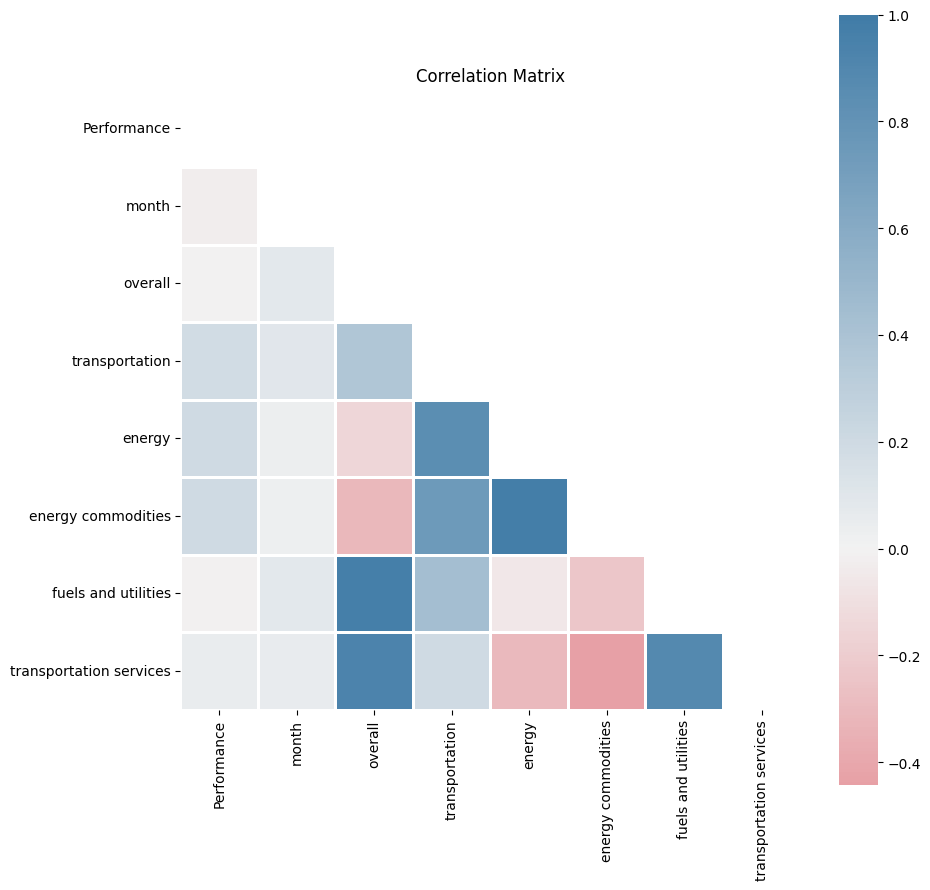

In [8]:
dd.correlation_matrix(original)

### Conditional GAN

In [9]:
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Materials (Sector),S&P 500 Performance (%),S&P 500 Materials (Sector) Performance (%),overall,transportation,energy,energy commodities,fuels and utilities,transportation services,dow
0,1,2048.299254,299.232681,-0.518033,9.448990,236.264289,210.223987,239.492360,304.163584,237.872354,274.399960,3
1,9,2150.487058,393.078786,-9.616589,-5.443509,246.193932,235.869652,246.732439,288.464722,269.530511,332.149096,3
2,7,1459.060135,225.026078,14.522684,15.954533,226.654686,217.020434,249.016938,316.983041,216.679896,280.604322,3
3,1,3001.013972,392.274263,-9.444046,-15.813170,254.131857,196.561732,205.350573,226.935410,234.751118,309.900233,3
4,9,3661.283783,299.447487,-4.810395,-4.985149,240.796251,198.572582,195.078184,187.176300,263.527284,316.884639,3
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,6,729.912636,164.309937,-5.359543,-3.093791,216.806509,193.541744,218.811322,268.732996,212.422211,253.889000,3
9996,1,1484.366375,217.493806,-5.826765,-2.166286,232.158363,217.758830,245.454499,302.518363,225.286759,279.436484,3
9997,1,2471.132532,292.854099,-4.553989,-1.811485,259.951891,203.855913,208.528389,221.306064,244.452551,320.441259,3
9998,4,4574.653362,372.460146,-4.187749,-4.808907,274.916526,198.613448,202.282996,208.269485,264.833798,325.092237,3


In [10]:
samples['Performance'] = np.where(samples['S&P 500 Materials (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)

In [11]:
samples = samples[['Performance','month', 'overall','transportation',\
                 'energy', 'energy commodities', 'fuels and utilities','transportation services']]
samples.head()

,Performance,month,overall,transportation,energy,energy commodities,fuels and utilities,transportation services
0,1,1,236.264289,210.223987,239.492360,304.163584,237.872354,274.399960
1,1,9,246.193932,235.869652,246.732439,288.464722,269.530511,332.149096
2,1,7,226.654686,217.020434,249.016938,316.983041,216.679896,280.604322
3,0,1,254.131857,196.561732,205.350573,226.935410,234.751118,309.900233
4,0,9,240.796251,198.572582,195.078184,187.176300,263.527284,316.884639


In [12]:
dd.data_summary(samples)

,Info
Rows,10000
Columns,8
Size in Memory,625.1 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,1,1,0.63,0.48,2,6318
month,int64,0,0,1,6,12,6.45,3.46,12,875
overall,float64,0,0,206.72,237.17,296.96,240.28,15.92,10000,1
transportation,float64,0,0,183.59,209.86,259.38,207.91,11.084,9999,2
energy,float64,0,0,173.18,217.34,260.017,222.66,19.55,9998,2
energy commodities,float64,0,0,150.87,244.35,339.44,255.066,42.37,10000,1
fuels and utilities,float64,0,0,205.18,233.13,282.96,231.87,14.31,10000,1
transportation services,float64,0,0,237.27,288.38,343.89,293.12,23.83,9999,2


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

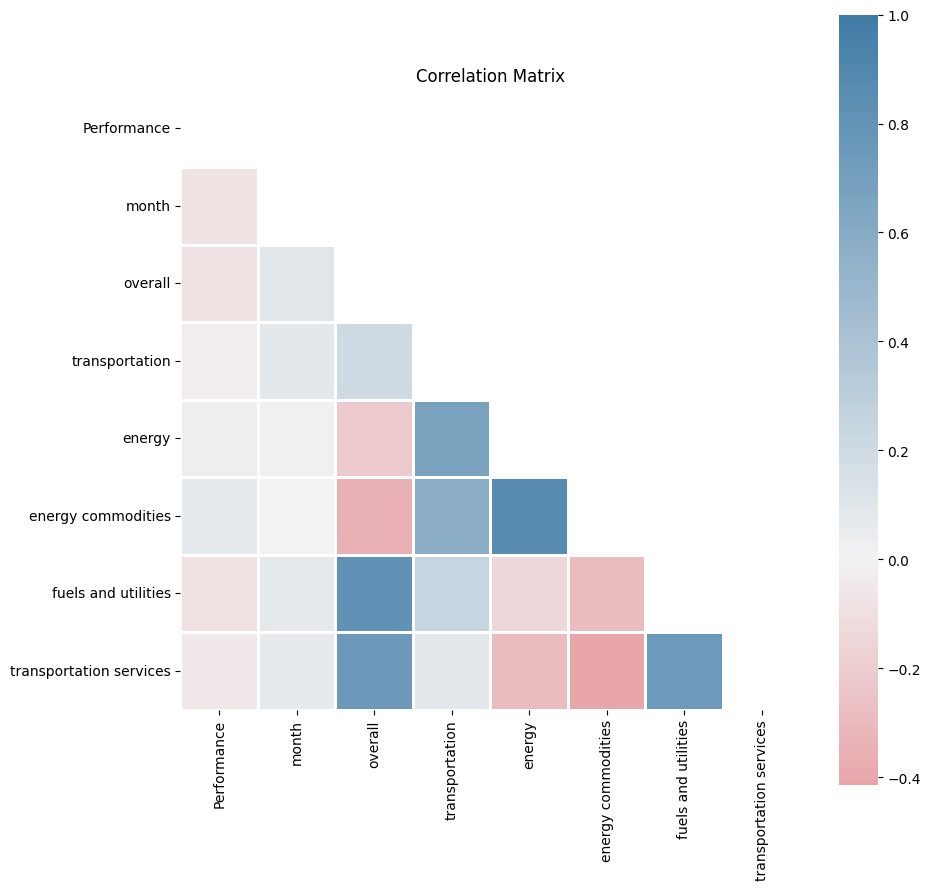

In [13]:
dd.correlation_matrix(samples)

In [14]:
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']

### SMOTE Oversampling

In [15]:
counter = Counter(y)
print(counter)
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
print(counter)

Counter({1: 6318, 0: 3682})
Counter({1: 6318, 0: 6318})


### Interaction Terms

In [16]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
X_poly

array([[  236.26428899,   210.22398687,   239.49235958, ...,
        72352.10778582, 83462.47539909, 65272.16449729],
       [  246.19393196,   235.86965197,   246.73243947, ...,
        77750.04376457, 95813.29650938, 89524.3154313 ],
       [  226.65468606,   217.02043421,   249.01693839, ...,
        68683.85230176, 88946.81129315, 60801.31526939],
       ...,
       [  248.95772204,   212.95372132,   210.45991045, ...,
        49944.63433284, 72726.74617054, 71442.36644722],
       [  248.82535969,   214.87313209,   212.3875873 , ...,
        55313.07068858, 71158.08618186, 72386.11913265],
       [  227.03704563,   220.05295432,   244.38749355, ...,
        65410.07726399, 79349.34117774, 62791.31436487]])

In [17]:
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X.shape

(12636, 22)

In [18]:
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
X_real.shape

(143, 22)

In [19]:
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)

### Training with CV

In [20]:
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.650774,0.688389,0.564263,0.618752,0.635644,0.660031,0.549395,0.599652,0.531469,0.605263,0.554217,0.578616
1,DecisionTreeClassifier,0.631385,0.645981,0.600187,0.620423,0.617601,0.619142,0.597833,0.608301,0.517483,0.585366,0.578313,0.581818
2,RandomForestClassifier,0.718999,0.762,0.667768,0.706677,0.701488,0.715565,0.662205,0.687852,0.587413,0.657895,0.60241,0.628931
3,AdaBoostClassifier,0.586896,0.591187,0.565055,0.57737,0.593542,0.591995,0.584449,0.588198,0.559441,0.65625,0.506024,0.571429
4,GradientBoostingClassifier,0.604863,0.616891,0.554926,0.584041,0.606838,0.609658,0.57935,0.594118,0.531469,0.637931,0.445783,0.524823
5,ExtraTreesClassifier,0.751686,0.791049,0.716673,0.746331,0.727762,0.733993,0.708732,0.721141,0.531469,0.593023,0.614458,0.60355
6,BaggingClassifier,0.667709,0.727478,0.553807,0.626091,0.654321,0.688836,0.554493,0.614407,0.482517,0.556962,0.53012,0.54321
7,SVC,0.584599,0.595926,0.526113,0.55872,0.581513,0.581951,0.558955,0.570221,0.552448,0.672727,0.445783,0.536232
8,GaussianNB,0.545822,0.545327,0.552547,0.548869,0.547009,0.542964,0.555768,0.549291,0.482517,0.571429,0.433735,0.493151


### Voting Classifier

In [21]:
et_clf = ExtraTreesClassifier(random_state=random_state)
bag_clf = BaggingClassifier(random_state=random_state)
rf_clf = RandomForestClassifier(random_state=random_state)
classifiers = [('RF', rf_clf), \
               ('ET', et_clf),\
              ('Bagging', bag_clf)]

vc = VotingClassifier(estimators = classifiers, voting = 'soft')     
vc.fit(x_train, y_train)
y_pred = vc.predict(x_test)
vc_res = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F-1 Score'])
vc_res.loc[0, 'Accuracy'] = accuracy_score(y_test, y_pred)
vc_res.loc[0, 'Precision'] = precision_score(y_test, y_pred)
vc_res.loc[0, 'Recall'] = recall_score(y_test, y_pred)
vc_res.loc[0, 'F-1 Score'] = f1_score(y_test, y_pred)
vc_res

,Accuracy,Precision,Recall,F-1 Score
0,0.708452,0.715712,0.68515,0.700098


## Using data after 2000 (Best Model)

In [22]:
data = pd.read_csv('../data/S&P 500 Materials 100-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2000]
data

,year,month,date,S&P 500,S&P 500 Materials (Sector),S&P 500 Performance (%),S&P 500 Materials (Sector) Performance (%),S&P 500 Materials (Sector) Outperform/Underperform,overall,transportation,energy,energy commodities,fuels and utilities,transportation services,dow
80,2000,1,2000-01-13,1449.68,161.000000,-1.473467,25.330835,OUTPERFORM,170.000,150.000,118.800,122.400,134.500,193.600,3
81,2000,2,2000-02-10,1416.83,134.789993,-2.032872,11.066242,OUTPERFORM,171.000,153.600,124.300,133.400,133.600,194.400,3
82,2000,3,2000-03-09,1401.69,122.080002,-2.531813,1.572510,OUTPERFORM,170.900,152.100,120.900,126.100,133.700,194.700,3
83,2000,4,2000-04-13,1440.51,144.729996,-3.467247,16.370501,OUTPERFORM,171.200,152.000,120.000,124.100,133.800,195.500,3
84,2000,5,2000-05-11,1407.81,138.949997,-1.307432,23.797220,OUTPERFORM,172.200,155.000,126.800,134.900,136.600,196.000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2021,7,2021-07-08,4320.82,511.019989,-7.184331,-6.095300,OUTPERFORM,273.092,236.783,242.958,276.734,262.483,326.470,3
339,2021,8,2021-08-12,4460.83,541.940002,-6.940799,-4.780817,OUTPERFORM,274.214,237.107,245.847,280.047,265.333,323.329,3
340,2021,9,2021-09-09,4493.28,525.940002,-1.171440,-2.502595,UNDERPERFORM,276.590,241.826,255.010,293.342,270.870,323.995,3
341,2021,10,2021-10-14,4438.26,526.789978,3.749053,2.205967,UNDERPERFORM,278.524,246.749,261.257,305.653,271.467,326.256,3


In [23]:
original = data[['S&P 500 Materials (Sector) Outperform/Underperform','month','overall','transportation',\
                 'energy', 'energy commodities', 'fuels and utilities','transportation services']]
data.drop(columns=['date','S&P 500 Materials (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Materials (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','transportation',\
                 'energy', 'energy commodities', 'fuels and utilities','transportation services']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Materials (Sector),S&P 500 Performance (%),S&P 500 Materials (Sector) Performance (%),overall,transportation,energy,energy commodities,fuels and utilities,transportation services,dow
0,9,3593.201380,424.587962,-3.762764,-12.073728,234.200407,225.756951,232.622511,302.984784,244.625845,311.883737,3
1,3,1092.345231,132.179172,-10.191534,-15.316881,180.679280,158.141229,125.280120,158.775214,146.526735,194.629190,3
2,4,1407.533608,201.263561,-6.242061,-1.059818,212.997456,158.602477,128.909417,174.131949,210.506009,219.258633,3
3,5,1641.387556,410.534776,-9.359056,-7.953948,233.379831,234.607455,241.691904,306.232855,258.558251,326.293845,3
4,3,1099.424361,95.235138,-2.092810,-9.202240,169.163297,157.276753,143.029941,153.170249,150.418875,207.212184,3
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3,1075.783866,126.760957,1.770803,-7.801647,168.848330,161.577268,153.648187,160.428703,157.541346,182.266362,3
9996,5,3643.743671,504.332370,13.640831,24.281717,256.390172,214.237549,232.983255,213.280514,264.112475,312.595474,3
9997,7,3443.622721,454.742533,-6.285726,-3.586997,275.741983,220.476842,244.273323,329.836314,261.008273,319.402347,3
9998,4,2550.122210,335.012372,-6.988399,-7.742244,233.677667,205.055773,188.036147,233.895240,233.925700,302.325131,3


In [24]:
samples['Performance'] = np.where(samples['S&P 500 Materials (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month', 'overall','transportation',\
                 'energy', 'energy commodities', 'fuels and utilities','transportation services']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.702636,0.661006,0.828335,0.734798,0.689204,0.64764,0.812289,0.72068,0.585551,0.565217,0.524194,0.543933
1,DecisionTreeClassifier,0.691577,0.677363,0.728869,0.701491,0.665554,0.652452,0.689966,0.670685,0.593156,0.593407,0.435484,0.502326
2,RandomForestClassifier,0.802528,0.77627,0.847267,0.808709,0.774346,0.744292,0.826945,0.783445,0.623574,0.634409,0.475806,0.543779
3,AdaBoostClassifier,0.647193,0.637489,0.681,0.658215,0.643851,0.631663,0.667982,0.649315,0.589354,0.568966,0.532258,0.55
4,GradientBoostingClassifier,0.669036,0.647002,0.742356,0.691018,0.657206,0.632713,0.728298,0.677149,0.604563,0.578125,0.596774,0.587302
5,ExtraTreesClassifier,0.838838,0.815996,0.873559,0.842095,0.807735,0.787573,0.835964,0.811047,0.612167,0.644737,0.395161,0.49
6,BaggingClassifier,0.755226,0.754057,0.754195,0.752168,0.726489,0.727691,0.712514,0.720023,0.619772,0.630435,0.467742,0.537037
7,SVC,0.633769,0.61368,0.720511,0.662615,0.630495,0.604303,0.728298,0.660532,0.585551,0.553957,0.620968,0.585551
8,GaussianNB,0.574429,0.557534,0.720783,0.62867,0.576795,0.554691,0.723224,0.627844,0.638783,0.593548,0.741935,0.659498


## Using all data

In [25]:
data = pd.read_csv('../data/S&P 500 Materials 100-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data

,year,month,date,S&P 500,S&P 500 Materials (Sector),S&P 500 Performance (%),S&P 500 Materials (Sector) Performance (%),S&P 500 Materials (Sector) Outperform/Underperform,overall,transportation,energy,energy commodities,fuels and utilities,transportation services,dow
0,1993,5,1993-05-13,439.23,90.330002,-4.763660,1.119445,OUTPERFORM,144.300,129.900,103.900,96.400,121.400,162.600,3
1,1993,6,1993-06-10,445.38,89.989998,-5.056491,-2.608229,OUTPERFORM,144.500,130.100,103.400,95.300,121.700,163.200,3
2,1993,7,1993-07-08,448.64,89.849998,-2.870751,-3.739017,UNDERPERFORM,144.800,130.500,103.400,95.000,122.100,163.900,3
3,1993,8,1993-08-12,448.96,89.269997,-3.840305,-9.204641,UNDERPERFORM,145.000,130.400,103.000,93.900,122.500,164.000,3
4,1993,9,1993-09-09,457.50,89.269997,-5.006125,-14.549635,UNDERPERFORM,145.600,132.000,105.300,98.300,122.600,164.400,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2021,7,2021-07-08,4320.82,511.019989,-7.184331,-6.095300,OUTPERFORM,273.092,236.783,242.958,276.734,262.483,326.470,3
339,2021,8,2021-08-12,4460.83,541.940002,-6.940799,-4.780817,OUTPERFORM,274.214,237.107,245.847,280.047,265.333,323.329,3
340,2021,9,2021-09-09,4493.28,525.940002,-1.171440,-2.502595,UNDERPERFORM,276.590,241.826,255.010,293.342,270.870,323.995,3
341,2021,10,2021-10-14,4438.26,526.789978,3.749053,2.205967,UNDERPERFORM,278.524,246.749,261.257,305.653,271.467,326.256,3


In [26]:
original = data[['S&P 500 Materials (Sector) Outperform/Underperform','month','overall','transportation',\
                 'energy', 'energy commodities', 'fuels and utilities','transportation services']]
data.drop(columns=['date','S&P 500 Materials (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Materials (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','transportation',\
                 'energy', 'energy commodities', 'fuels and utilities','transportation services']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Materials (Sector),S&P 500 Performance (%),S&P 500 Materials (Sector) Performance (%),overall,transportation,energy,energy commodities,fuels and utilities,transportation services,dow
0,8,1326.614739,331.961480,2.646351,2.784620,229.554532,197.971907,219.552740,298.060751,215.252170,236.791954,3
1,2,2894.587650,259.215039,7.102639,27.277291,237.718307,209.202335,254.778601,332.525993,231.752471,290.489794,3
2,6,184.548693,111.275796,-6.514554,18.449785,148.382400,147.243058,120.161415,126.575797,132.352866,194.001569,3
3,1,1866.131008,260.442436,-4.121369,9.039388,225.631532,183.794232,189.516598,227.514693,207.047206,245.181873,3
4,3,148.227236,104.013425,-7.357271,-6.070715,157.564559,149.700355,128.420095,110.491914,137.340790,185.192467,3
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,11,388.094644,107.545508,-0.089366,-10.558685,166.038106,139.289026,112.201117,102.409807,134.644203,224.408803,3
9996,6,1187.025470,148.565114,0.662296,29.252144,207.842778,144.046232,204.965704,117.662577,123.220200,223.430803,3
9997,3,856.561238,116.382539,-11.714654,-9.356570,163.223922,144.117075,117.141390,88.729454,130.330286,174.984997,3
9998,6,762.351792,123.339259,5.018409,2.386109,172.635258,147.254775,124.833800,113.524998,149.877241,195.964130,3


In [27]:
samples['Performance'] = np.where(samples['S&P 500 Materials (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month', 'overall','transportation',\
                 'energy', 'energy commodities', 'fuels and utilities','transportation services']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.613707,0.63371,0.554191,0.58985,0.584778,0.613636,0.508475,0.556128,0.45481,0.484536,0.519337,0.501333
1,DecisionTreeClassifier,0.619648,0.634602,0.584853,0.606362,0.588632,0.607143,0.554928,0.579862,0.489796,0.514423,0.59116,0.550129
2,RandomForestClassifier,0.70316,0.731225,0.667891,0.694485,0.676943,0.708304,0.626491,0.66489,0.419825,0.455,0.502762,0.47769
3,AdaBoostClassifier,0.587439,0.588062,0.583747,0.585711,0.576429,0.592568,0.550534,0.570778,0.48105,0.509091,0.464088,0.485549
4,GradientBoostingClassifier,0.599563,0.598606,0.603497,0.600892,0.587669,0.60225,0.571249,0.58634,0.501458,0.531646,0.464088,0.495575
5,ExtraTreesClassifier,0.731349,0.762954,0.706435,0.728113,0.70456,0.730322,0.669805,0.698756,0.446064,0.482072,0.668508,0.560185
6,BaggingClassifier,0.641972,0.687558,0.537011,0.600854,0.641297,0.691318,0.539862,0.606274,0.498542,0.527273,0.480663,0.50289
7,SVC,0.577723,0.581952,0.552113,0.566597,0.57097,0.591851,0.519774,0.553476,0.565598,0.608108,0.497238,0.547112
8,GaussianNB,0.5387,0.542271,0.496863,0.518535,0.543674,0.562139,0.488387,0.522674,0.556851,0.596026,0.497238,0.542169
